In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import joblib
import xgboost as xgb

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
data_path = '/content/gdrive/My Drive/ENERGY_CLIMATE_HACK/raw_data/'
df = pd.read_csv(f'{data_path}clean_data.csv')

In [4]:
df_1 = df.copy()

In [5]:
## Change to relative terms
absolute_vars = ["permanent_resident_population", "swiss_citizen", "foreign_citizen", "age_0to14", "age_15to19", "age_20to39", "age_40to59", "age_60to64", "age_65tomore", "men", "women"]
relative_vars = ["permanent_resident_population_%", "swiss_citizen_%", "foreign_citizen_%", "age_0to14_%", "age_15to19_%", "age_20to39_%", "age_40to59_%", "age_60to64_%", "age_65tomore_%", "men_%"]
drop_vars = ["permanent_resident_population", "swiss_citizen", "foreign_citizen", "age_0to14", "age_15to19", "age_20to39", "age_40to59", "age_60to64", "age_65tomore", "men", "women", 
             "Unnamed: 0", "region_id", "kanton_number",	"kanton_short", "district_number", "temp_stdev", "pv_out_std", "municipality_type"]


In [6]:
for a, r in zip(absolute_vars, relative_vars):
  df_1[r] = df_1[a]/df_1["population"]
for i in drop_vars:
  df_1 = df_1.drop([i], axis = 1)
df_1.head(3)

,region_name,percentage_population_in_detached_houses,population,population_per_km2,percentage_detached_houses,percentage_flats_3to4_rooms,district_name,kanton_name,taxable_income_in_mio_CHF,taxable_income_per_taxable_person_in_chf,share_electric_cars,share_pv,share_renewable_heating,Heating data coverage,mean_electricity_tarif_2021_rp_per_kwh,% Ja,% participation,vote_accepted,vote_bins,temp_mean,pv_out_mea,NUMPOINTS,permanent_resident_population_%,swiss_citizen_%,foreign_citizen_%,age_0to14_%,age_15to19_%,age_20to39_%,age_40to59_%,age_60to64_%,age_65tomore_%,men_%
0,Aeugst am Albis,49.555336,1981,250.442478,69.565217,41.900648,Affoltern,Zürich,94.4072,105013.57060,0.02731,0.07149,0.6129,0.9928,15.486667,55.41,59.46,1,marginally for,9.992784,3.248851,15,1.000000,0.872287,0.127713,0.155982,0.062090,0.197375,0.357900,0.065119,0.161535,0.498233
1,Obfelden,42.616626,5721,758.753316,72.784314,52.324195,Affoltern,Zürich,158.0976,75105.74822,0.01728,0.04280,0.4325,0.7072,15.486667,55.41,59.46,1,marginally for,9.992784,3.248851,15,0.875546,0.703723,0.171823,0.154344,0.049467,0.202237,0.272680,0.053662,0.143157,0.437161
2,Stadel,36.837533,2293,177.889837,58.333333,45.512821,Dielsdorf,Zürich,74.0686,73920.75848,0.01727,0.02390,0.4191,0.9885,15.486667,55.41,59.46,1,marginally for,10.088192,3.238797,17,0.961622,0.830789,0.130833,0.150458,0.056694,0.225469,0.321413,0.061491,0.146097,0.478849


In [7]:
## One hot encoding: vote_bins
one_hot = pd.get_dummies(df_1['vote_bins'])
one_hot
# Drop column vote_bins as it is now encoded
df_1 = df_1.drop('vote_bins',axis = 1)
# Join the encoded df
df_2 = df_1.join(one_hot)
df_2

,region_name,percentage_population_in_detached_houses,population,population_per_km2,percentage_detached_houses,percentage_flats_3to4_rooms,district_name,kanton_name,taxable_income_in_mio_CHF,taxable_income_per_taxable_person_in_chf,share_electric_cars,share_pv,share_renewable_heating,Heating data coverage,mean_electricity_tarif_2021_rp_per_kwh,% Ja,% participation,vote_accepted,temp_mean,pv_out_mea,NUMPOINTS,permanent_resident_population_%,swiss_citizen_%,foreign_citizen_%,age_0to14_%,age_15to19_%,age_20to39_%,age_40to59_%,age_60to64_%,age_65tomore_%,men_%,marginally against,marginally for,strongly against,strongly for
0,Aeugst am Albis,49.555336,1981,250.442478,69.565217,41.900648,Affoltern,Zürich,94.4072,105013.57060,0.02731,0.07149,0.6129,0.9928,15.486667,55.41,59.46,1,9.992784,3.248851,15,1.000000,0.872287,0.127713,0.155982,0.062090,0.197375,0.357900,0.065119,0.161535,0.498233,0,1,0,0
1,Obfelden,42.616626,5721,758.753316,72.784314,52.324195,Affoltern,Zürich,158.0976,75105.74822,0.01728,0.04280,0.4325,0.7072,15.486667,55.41,59.46,1,9.992784,3.248851,15,0.875546,0.703723,0.171823,0.154344,0.049467,0.202237,0.272680,0.053662,0.143157,0.437161,0,1,0,0
2,Stadel,36.837533,2293,177.889837,58.333333,45.512821,Dielsdorf,Zürich,74.0686,73920.75848,0.01727,0.02390,0.4191,0.9885,15.486667,55.41,59.46,1,10.088192,3.238797,17,0.961622,0.830789,0.130833,0.150458,0.056694,0.225469,0.321413,0.061491,0.146097,0.478849,0,1,0,0
3,Doppleschwand,31.632653,789,113.525180,42.647059,40.909091,Entlebuch,Luzern,13.1697,53318.62348,0.00190,0.07290,0.5942,0.9615,15.367333,47.98,65.23,0,6.911748,3.130781,9,0.950570,0.904943,0.045627,0.207858,0.068441,0.237009,0.261090,0.039290,0.136882,0.498099,1,0,0,0
4,Entlebuch,23.524041,3280,57.644991,36.800895,48.755313,Entlebuch,Luzern,72.6600,55170.84282,0.00482,0.08571,0.6174,0.6046,15.367333,47.98,65.23,0,6.911748,3.130781,9,1.021037,0.946951,0.074085,0.165549,0.066768,0.273780,0.276220,0.060671,0.178049,0.528354,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016,Schöfflisdorf,43.988685,1377,343.391521,70.338983,44.907407,Dielsdorf,Zürich,54.6657,82080.63063,0.01864,0.02482,0.3616,0.9940,15.486667,55.41,59.46,1,10.088192,3.238797,17,1.013798,0.852578,0.161220,0.150327,0.050109,0.205519,0.347858,0.064633,0.195352,0.494553,0,1,0,0
2017,Walliswil bei Niederbipp,52.534562,217,147.619048,70.129870,55.833333,Oberaargau,Bern / Berne,6.5089,56599.13043,0.02732,0.05957,0.3766,0.6037,21.925714,48.49,62.28,0,9.809375,3.286482,5,1.032258,0.935484,0.096774,0.115207,0.036866,0.225806,0.299539,0.138249,0.216590,0.502304,1,0,0,0
2018,Walliswil bei Wangen,57.575758,606,197.394137,71.232877,54.487179,Oberaargau,Bern / Berne,16.8741,59207.36842,0.00671,0.05395,0.3761,0.9955,21.925714,48.49,62.28,0,9.809375,3.286482,5,0.953795,0.917492,0.036304,0.105611,0.044554,0.202970,0.316832,0.084158,0.199670,0.471947,1,0,0,0
2019,Wangen an der Aare,37.056055,2321,444.636015,59.897611,57.797428,Oberaargau,Bern / Berne,61.6100,61242.54473,0.00672,0.06549,0.2902,0.9653,21.925714,48.49,62.28,0,9.809375,3.286482,5,0.979750,0.845756,0.133994,0.143473,0.052133,0.255062,0.291254,0.054718,0.183111,0.484274,1,0,0,0


In [8]:
## Tree models 

In [9]:
df_2.columns

Index(['region_name', 'percentage_population_in_detached_houses', 'population',
       'population_per_km2', 'percentage_detached_houses',
       'percentage_flats_3to4_rooms', 'district_name', 'kanton_name',
       'taxable_income_in_mio_CHF', 'taxable_income_per_taxable_person_in_chf',
       'share_electric_cars', 'share_pv', 'share_renewable_heating',
       'Heating data coverage', 'mean_electricity_tarif_2021_rp_per_kwh',
       '% Ja', '% participation', 'vote_accepted', 'temp_mean', 'pv_out_mea',
       'NUMPOINTS', 'permanent_resident_population_%', 'swiss_citizen_%',
       'foreign_citizen_%', 'age_0to14_%', 'age_15to19_%', 'age_20to39_%',
       'age_40to59_%', 'age_60to64_%', 'age_65tomore_%', 'men_%',
       'marginally against', 'marginally for', 'strongly against',
       'strongly for'],
      dtype='object')

In [10]:
idx_cols = ['region_name', 'district_name', 'kanton_name']
drop_cats = ['marginally against', 'marginally for', 'strongly against','strongly for']
targets = ['share_electric_cars', 'share_pv', 'share_renewable_heating']

In [11]:
df_2 = df_2.sample(frac=1).reset_index(drop=True)
df_2[idx_cols].to_csv(data_path + "index_cols.csv")


In [12]:
df_2 = df_2.drop(idx_cols, axis=1)
df_2 = df_2.drop(drop_cats, axis=1)
df_corr = df_2.copy()
targets = df_2[targets]
data = df_2.drop(targets, axis=1)
data_df = data.copy()

In [13]:
#saving column names as list
columns = data.columns 
target_cols = targets.columns
#saving so we dont lose them
np.save(data_path + '/col_names_full.npy', columns.to_numpy())
np.save(data_path + '/target_names_full.npy', target_cols.to_numpy())

In [14]:
#turn data to numpy array
np.random.seed(6)
data = np.array(data)
targets = np.array(targets)
print("data has shape: " + str(data.shape))
print("targets has shape: " + str(targets.shape))

data has shape: (2021, 25)
targets has shape: (2021, 3)


In [15]:
#saving data for reference
np.save(data_path + '/data.npy', data) 
np.save(data_path + '/targets.npy', targets) 

In [16]:
len(targets[:, 1])

2021

In [17]:
#hyperparam tuning
# creating data matrix

DATA_EV = xgb.DMatrix(data, label=targets[:, 0])
DATA_PV = xgb.DMatrix(data, label=targets[:, 1])
DATA_HEAT = xgb.DMatrix(data, label=targets[:, 2])

In [18]:
# starting params
params = {
    'max_depth':6,
    'min_child_weight': 1,
    'eta':0.3,
    'subsample': 1,
    'colsample_bytree': 1,
    'objective':'reg:squarederror',
    'eval_metric': 'mae'
}

In [19]:
model = xgb.cv(
    params, 
    DATA_EV,
    num_boost_round=1000,
    seed=42,
    nfold=5,
    metrics={'mae'},
    early_stopping_rounds=10
)

In [20]:
model

,train-mae-mean,train-mae-std,test-mae-mean,test-mae-std
0,0.341812,0.000032,0.341812,0.000199
1,0.239332,0.000022,0.239332,0.000209
2,0.167577,0.000016,0.167577,0.000216
3,0.117335,0.000011,0.117335,0.000220
4,0.082160,0.000008,0.082159,0.000226
5,0.057576,0.000021,0.057580,0.000264
6,0.040352,0.000031,0.040410,0.000303
7,0.028303,0.000029,0.028401,0.000358
8,0.019915,0.000027,0.020101,0.000408
9,0.014061,0.000027,0.014355,0.000416


In [21]:
model['test-mae-mean'].min()

0.0041586

In [22]:
gridsearch_params = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

def max_depth(params, data):
       
    params_cv = params.copy()
    # Define initial best params and MAE
    min_mae = float("Inf")
    best_params = None
    for max_depth in gridsearch_params:
        print(f"CV with maxdepth = {max_depth}")
        # Update our parameters
        params_cv['max_depth'] = max_depth
        # Run CV
        cv_results = xgb.cv(
            params_cv,
            data,
            num_boost_round=2000,
            seed=42,
            nfold=5,
            metrics={'mae'},
            early_stopping_rounds=10
        )
        # Update best MAE
        mean_mae = cv_results['test-mae-mean'].min()
        boost_rounds = cv_results['test-mae-mean'].argmin()
        print("\tMAE %.5f after %.5f rounds" % (mean_mae, boost_rounds))
        if mean_mae < min_mae:
            min_mae = mean_mae
            best_params = (max_depth)
    params['max_depth'] = best_params
    print("Best params: max_depth: %.3f, MAE: %.5f" % (best_params, min_mae))

In [23]:
max_depth(params, DATA_EV)

CV with maxdepth = 3
	MAE 0.00397 after 28.00000 rounds
CV with maxdepth = 4
	MAE 0.00405 after 29.00000 rounds
CV with maxdepth = 5
	MAE 0.00408 after 26.00000 rounds
CV with maxdepth = 6
	MAE 0.00416 after 21.00000 rounds
CV with maxdepth = 7
	MAE 0.00419 after 22.00000 rounds
CV with maxdepth = 8
	MAE 0.00425 after 23.00000 rounds
CV with maxdepth = 9
	MAE 0.00427 after 30.00000 rounds
CV with maxdepth = 10
	MAE 0.00431 after 36.00000 rounds
CV with maxdepth = 11
	MAE 0.00431 after 37.00000 rounds
CV with maxdepth = 12
	MAE 0.00437 after 35.00000 rounds
Best params: max_depth: 3.000, MAE: 0.00397


In [24]:
gridsearch_params = [np.round(i, 2) for i in np.linspace(0.05, 0.1, 5)]

def eta(params, data):
       
    params_cv = params.copy()
    # Define initial best params and MAE
    min_mae = float("Inf")
    best_params = None
    for eta in gridsearch_params:
        print("CV with eta = %.3f" % (eta))
        # Update our parameters
        params_cv['eta'] = eta
        # Run CV
        cv_results = xgb.cv(
            params_cv,
            data,
            num_boost_round=2000,
            seed=42,
            nfold=5,
            metrics={'mae'},
            early_stopping_rounds=10
        )
        # Update best MAE
        mean_mae = cv_results['test-mae-mean'].min()
        boost_rounds = cv_results['test-mae-mean'].argmin()
        print("\tMAE %.5f after %.5f rounds" % (mean_mae, boost_rounds))
        if mean_mae < min_mae:
            min_mae = mean_mae
            best_params = (eta)
    params['eta'] = best_params
    print("Best params: eta: %.3f, MAE: %.5f" % (best_params, min_mae))

In [25]:
eta(params, DATA_EV)

CV with eta = 0.050
	MAE 0.00389 after 195.00000 rounds
CV with eta = 0.060
	MAE 0.00388 after 151.00000 rounds
CV with eta = 0.080
	MAE 0.00389 after 121.00000 rounds
CV with eta = 0.090
	MAE 0.00388 after 97.00000 rounds
CV with eta = 0.100
	MAE 0.00390 after 104.00000 rounds
Best params: eta: 0.090, MAE: 0.00388


In [26]:
params

{'colsample_bytree': 1,
 'eta': 0.09,
 'eval_metric': 'mae',
 'max_depth': 3,
 'min_child_weight': 1,
 'objective': 'reg:squarederror',
 'subsample': 1}

In [27]:
#training all models

In [28]:
xg_model_ev = xgb.train(
    params,
    DATA_EV,
    num_boost_round=100,
)

xg_model_pv = xgb.train(
    params,
    DATA_PV,
    num_boost_round=100,
)

xg_model_heat = xgb.train(
    params,
    DATA_HEAT,
    num_boost_round=100,
)

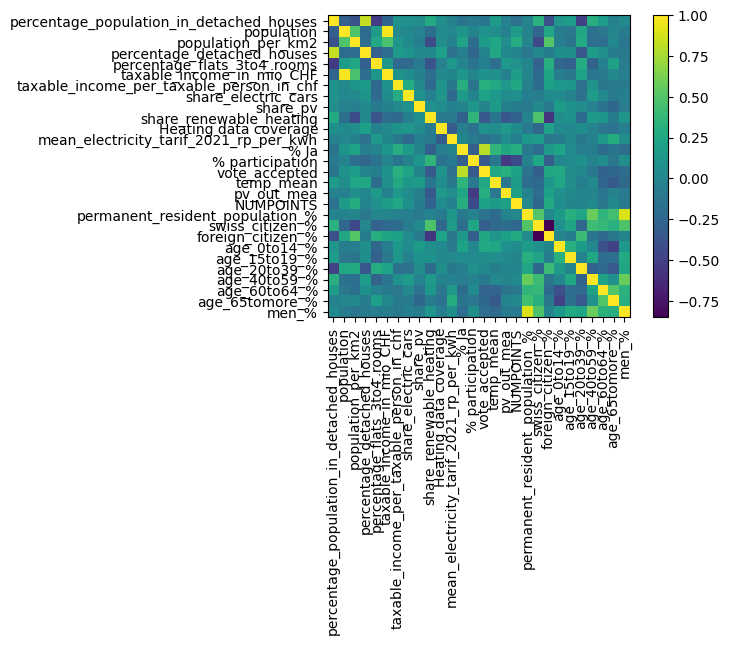

In [114]:
#correlation full data
CORR_FEATURES = df_corr.columns

idx = np.arange(0, len(CORR_FEATURES))
fig, ax = plt.subplots(1, 1, dpi = 100)
im = ax.imshow(df_corr.corr())
ax.set_xticks(idx)
ax.set_yticks(idx)
ax.set_xticklabels([x for x in df_corr.columns if x in CORR_FEATURES], rotation='vertical')
ax.set_yticklabels([x for x in df_corr.columns if x in CORR_FEATURES])
plt.colorbar(im)
plt.show()

In [30]:
# feature importance
def mae(y, yhat):
    """
    Computes Mean Absolute Error
    """
    return np.sum(np.abs(np.array(y) - np.array(yhat))) / len(np.array(y))

In [31]:
def permutation_importance(model, x, y, target):
    """
    Takes features and target and calculates permutation importance
    by predicting y for each shuffled feature in turn. 'azimuth_sin'
    and 'azimuth_cos' are highly correlated so we drop both these columns 
    together.
    Args:
        x: Validation set
        y: True target 
        target: name of target. either 'dgp' or 'ill'
    """
    
    if target == 'ev':
        target_index = 0
    elif target == 'pv':
        target_index = 1
    else:
        target_index = 2
        
    x = x.copy()
    y = y.copy()
        
    X_XGB = xgb.DMatrix(x, label=y[:,target_index].copy())
    
    model = model
    #getting baseline mae score for fully trained XGB model
    baseline = mae(model.predict(X_XGB), y[:,target_index])
    imp = []
    for i in range(x.shape[1]):
        save = x[:,i].copy()
        x[:,i] = np.random.permutation(x[:,i])
        X_XGB = xgb.DMatrix(x, label=y[:,target_index].copy())
        loss = mae(model.predict(X_XGB), y[:,target_index])
        x[:,i] = save
        imp.append(abs(baseline - loss))
    return np.array(imp)

In [32]:
per_imp_ev = permutation_importance(xg_model_ev, data, targets, 'ev')
per_imp_pv = permutation_importance(xg_model_pv, data, targets, 'pv')
per_imp_heat = permutation_importance(xg_model_heat, data, targets, 'heat')

In [33]:
def plot_permutation_importance(imps, features, target):
    
    features = features
    imp = pd.Series(imps, index=features)
    sorted_ix = imp.sort_values().index
    ax = imp[sorted_ix].plot(kind='barh', width = .7, color='royalblue', alpha=0.9, figsize=(8,12))
    ax.set_title('Permutation importance ' + target)
    ax.set_xlabel('Change in MAE')
    ax.grid(color='k', ls = '-.', lw = 0.2, axis='x')
    plt.show()

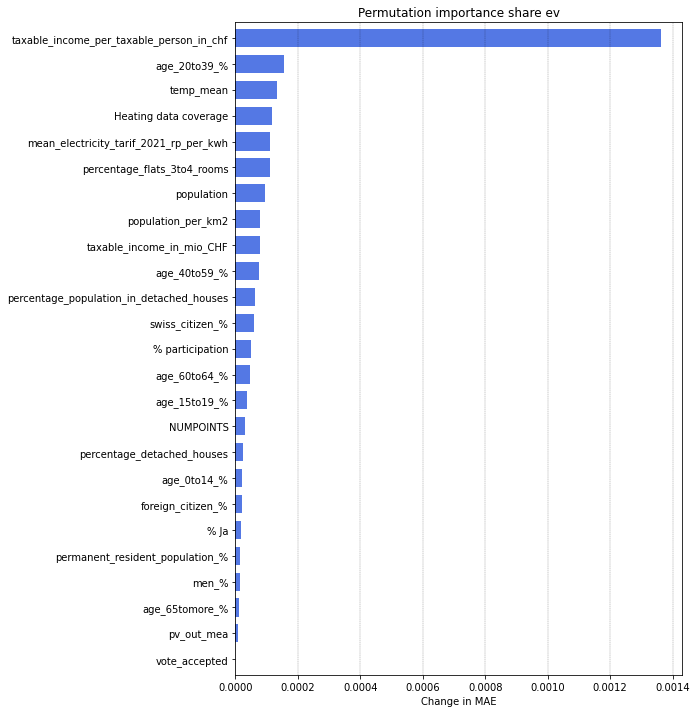

In [34]:
plot_permutation_importance(per_imp_ev, columns, 'share ev')

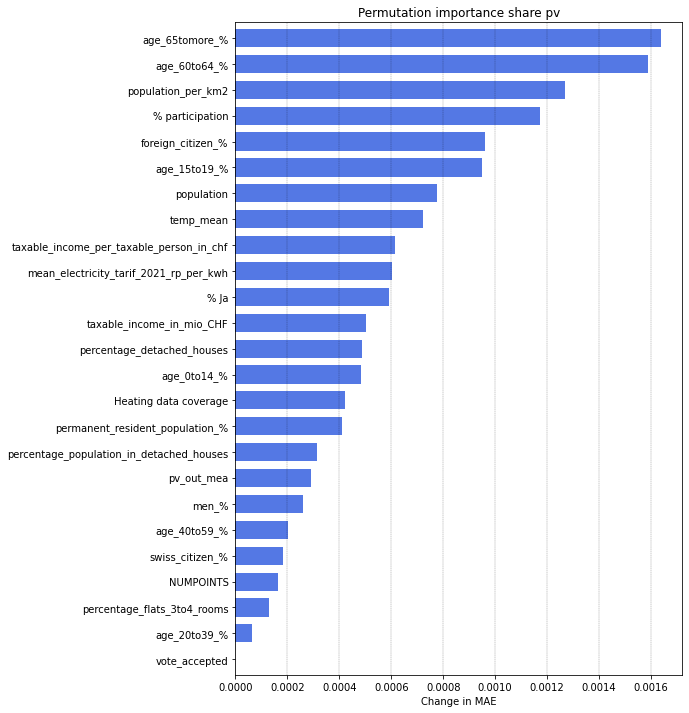

In [35]:
plot_permutation_importance(per_imp_pv, columns, 'share pv')

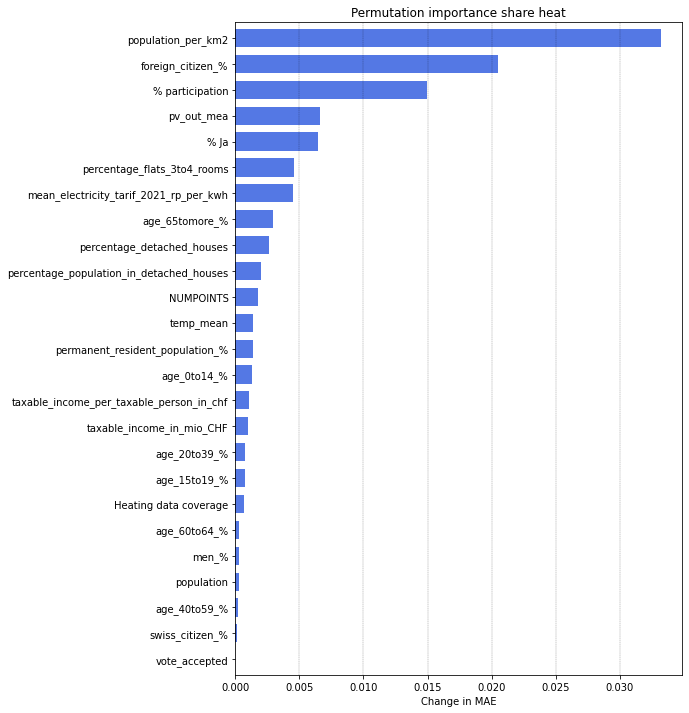

In [36]:
plot_permutation_importance(per_imp_heat, columns, 'share heat')

In [37]:
# shapley
!pip install shap
import shap

In [45]:
shap_values_ev = shap.TreeExplainer(xg_model_ev).shap_values(data_df)
shap_values_pv = shap.TreeExplainer(xg_model_pv).shap_values(data_df)
shap_values_heat = shap.TreeExplainer(xg_model_heat).shap_values(data_df)

In [49]:
data_df.columns

Index(['percentage_population_in_detached_houses', 'population',
       'population_per_km2', 'percentage_detached_houses',
       'percentage_flats_3to4_rooms', 'taxable_income_in_mio_CHF',
       'taxable_income_per_taxable_person_in_chf', 'Heating data coverage',
       'mean_electricity_tarif_2021_rp_per_kwh', '% Ja', '% participation',
       'vote_accepted', 'temp_mean', 'pv_out_mea', 'NUMPOINTS',
       'permanent_resident_population_%', 'swiss_citizen_%',
       'foreign_citizen_%', 'age_0to14_%', 'age_15to19_%', 'age_20to39_%',
       'age_40to59_%', 'age_60to64_%', 'age_65tomore_%', 'men_%'],
      dtype='object')

In [76]:
explainer = shap.TreeExplainer(xg_model_ev)
expected_value = explainer.expected_value

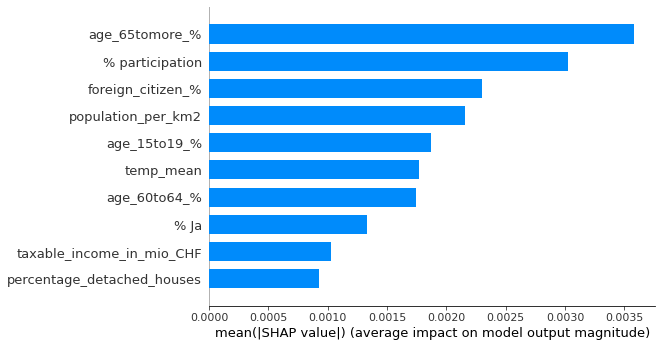

In [48]:
shap.summary_plot(shap_values_pv, data_df, plot_type = 'bar', max_display=10)

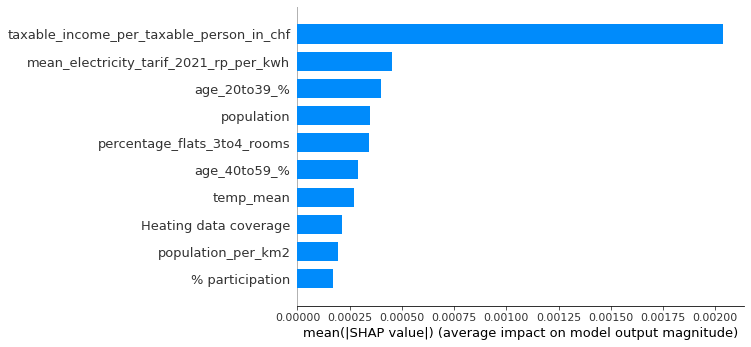

In [106]:
shap.summary_plot(shap_values_ev, data_df, plot_type = 'bar', max_display=10)

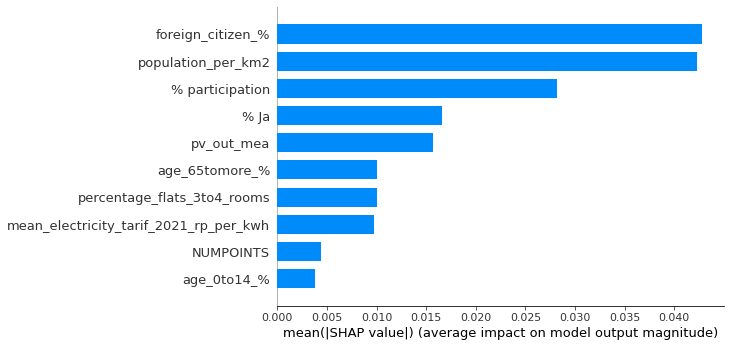

In [107]:
shap.summary_plot(shap_values_heat, data_df, plot_type = 'bar', max_display=10)

In [47]:
# interactions

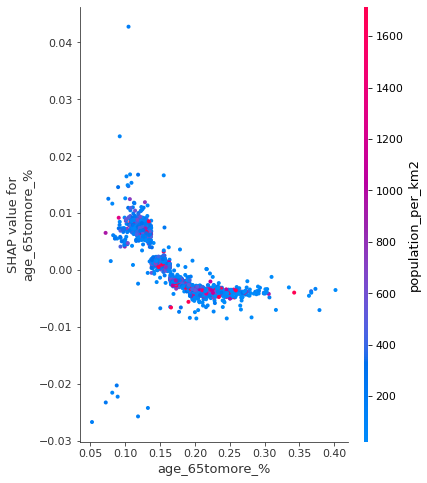

In [123]:
fig, ax = plt.subplots(figsize=(6,8))
shap.dependence_plot(23, shap_values_pv, data_df, interaction_index=2, ax=ax)

In [51]:
shap_values_pv

array([[ 4.3987116e-04,  1.1747364e-04,  8.5827603e-04, ...,
        -8.2033430e-04, -2.0067929e-03, -1.3532954e-04],
       [ 1.6765139e-03,  6.8880571e-04, -4.9685419e-04, ...,
        -3.4570749e-04,  6.7638494e-03,  3.9377200e-04],
       [ 3.8457938e-06,  4.7593913e-04,  3.7353035e-04, ...,
         4.0704315e-03,  7.2041559e-03, -8.3962129e-04],
       ...,
       [-1.0309090e-04,  5.0738314e-04,  7.6272007e-04, ...,
        -7.8596186e-04,  3.2516022e-04, -5.3830503e-05],
       [-3.3356580e-05,  2.9391311e-03,  1.0798093e-03, ...,
        -1.8176263e-03,  9.8296115e-04,  4.1369157e-04],
       [-6.8544039e-05,  4.8722792e-04,  5.1038119e-04, ...,
        -1.9137274e-03, -2.8280448e-03,  2.6830591e-04]], dtype=float32)

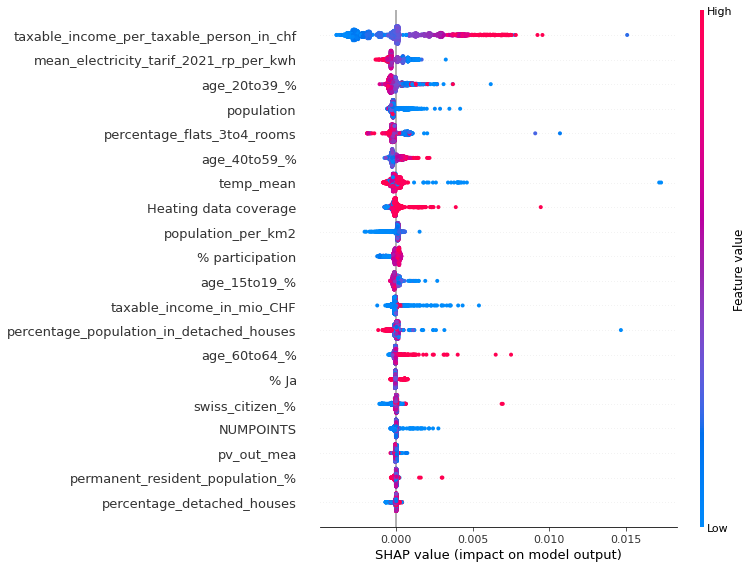

In [100]:
shap.summary_plot(shap_values_ev, data_df)

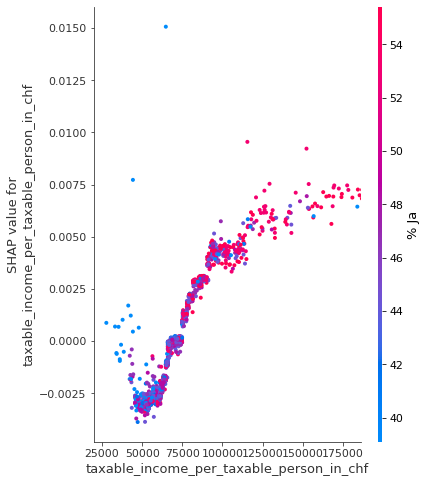

In [133]:
fig, ax = plt.subplots(figsize=(6,8))


shap.dependence_plot(6, shap_values_ev, data_df, interaction_index=9, ax=ax, xmax = 'percentile('+str(99)+')')

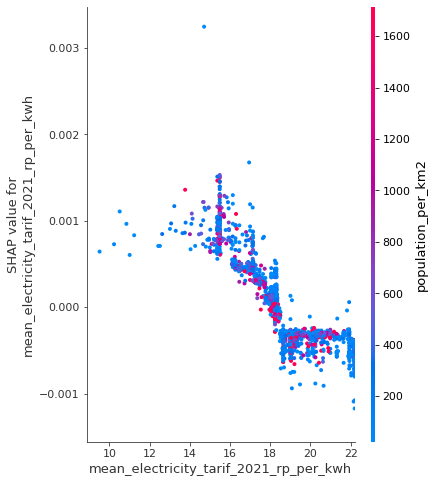

In [124]:
fig, ax = plt.subplots(figsize=(6,8))


shap.dependence_plot(8, shap_values_ev, data_df, interaction_index=2, ax=ax, xmax = 'percentile('+str(90)+')')

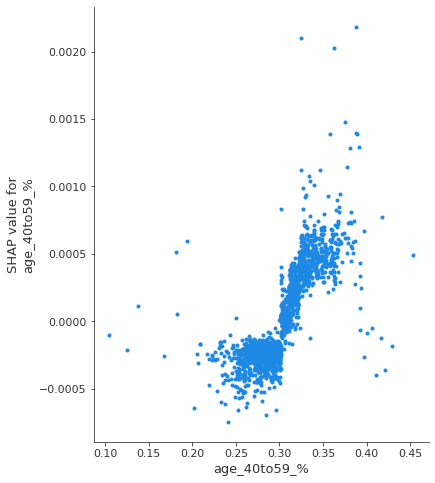

In [112]:
fig, ax = plt.subplots(figsize=(6,8))


shap.dependence_plot(21, shap_values_ev, data_df, interaction_index=None, ax=ax, xmax = 'percentile('+str(100)+')')

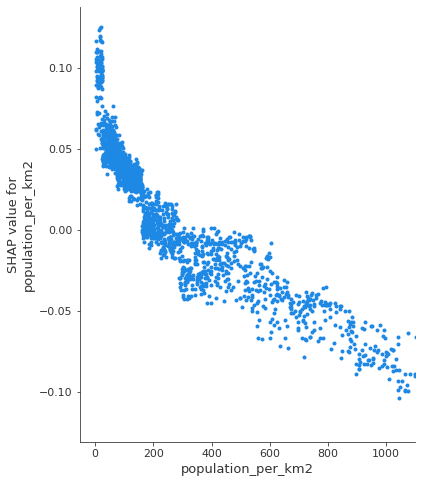

In [116]:
fig, ax = plt.subplots(figsize=(6,8))


shap.dependence_plot(2, shap_values_heat, data_df, interaction_index=None, ax=ax, xmax = 'percentile('+str(90)+')')

ValueError: ignored

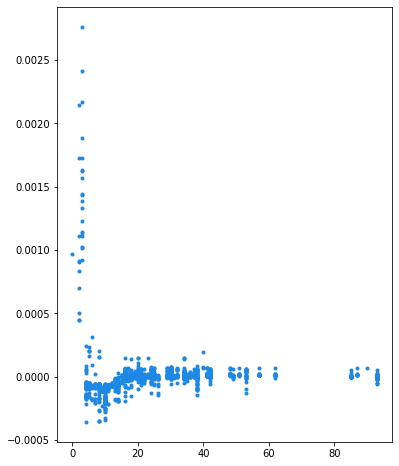

In [121]:
fig, ax = plt.subplots(figsize=(6,8))

shap.dependence_plot(14, shap_values_ev, data_df, interaction_index=None, ax=ax, xmax = 'percentile('+str([0, 100])+')')

In [102]:
for i, j in enumerate(data_df.columns):
  print(i, j)

0 percentage_population_in_detached_houses
1 population
2 population_per_km2
3 percentage_detached_houses
4 percentage_flats_3to4_rooms
5 taxable_income_in_mio_CHF
6 taxable_income_per_taxable_person_in_chf
7 Heating data coverage
8 mean_electricity_tarif_2021_rp_per_kwh
9 % Ja
10 % participation
11 vote_accepted
12 temp_mean
13 pv_out_mea
14 NUMPOINTS
15 permanent_resident_population_%
16 swiss_citizen_%
17 foreign_citizen_%
18 age_0to14_%
19 age_15to19_%
20 age_20to39_%
21 age_40to59_%
22 age_60to64_%
23 age_65tomore_%
24 men_%


In [147]:
shap.initjs()
shap.force_plot(expected_value, shap_values_ev[1559,:], data_df.iloc[1559,:], link="logit")

In [149]:
shap.initjs()
shap.force_plot(expected_value, shap_values_ev[1940,:], data_df.iloc[1940,:], link="logit")

In [145]:
df_2.to_csv(data_path + "DATATO.csv")

In [150]:
shap.initjs()
shap.force_plot(expected_value, shap_values_ev[1560,:], data_df.iloc[1560,:], link="logit")

In [151]:
shap.initjs()
shap.force_plot(expected_value, shap_values_ev[1949,:], data_df.iloc[1949,:], link="logit")

In [156]:
shap.initjs()
shap.force_plot(expected_value, shap_values_ev[1953,:], data_df.iloc[1953,:], link="identity")